## What is the free energy of applying a double harmonic restraint?

By this we mean a rigid molecule with two atoms harmonically restrained at their fixed positions.

Matt Hurley \
Vincent Voelz
May 21, 2021


# Function definitions

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R
import copy

# NOTES
# I left out the c_i and x_i from the above toy-ee implementation, do I need these?
### VAV: No -- those were for a different system of potentials: a series of shifted harmonic wells.

# Gaussian/translation step size seems fine, rotational *could* be limited to improve acceptance
# Tweaked flatness/scaling/initial increment a bit to improve performance


## NOTES from VAV:
# Matt:
# I modified your code to use arrays rather than lists, and to have definite *units*
# This will be helpful in determining whether our math is correct!

def u(p1, p2, k, a1=np.array([0,0,0]), a2=np.array([1,0,0])):
    """Returns the energy of the harmonic potential in units kJ/mol.
    
    INPUTS
    p1, p2 -- position vectors of each particle as a np.array (nm)*3
    k      -- the force constant  (kJ/nm^2)
    a1, a2 -- the anchor positions of the harmonic potentials for particles 1 and 2.
    
    OUTPUTS
    u      -- the energy
    """
    p1_pot = 0.5*k*( np.dot(p1-a1, p1-a1) )
    p2_pot = 0.5*k*( np.dot(p2-a2, p2-a2) )
    return p1_pot + p2_pot

# returns rotated vectors
def dist(_p1,_p2):
    return np.sqrt(np.sum((_p1-_p2)**2, axis=0))

def rot_x(v, theta):
    return np.dot(np.asarray([[1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]]), v)

def rot_y(v, theta):
    return np.dot(np.asarray([[np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0,  np.cos(theta)]]), v)

def rot_z(v, theta):
    return np.dot(np.asarray([[np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]]), v)

def sigmoid(x):
    return (min_k + max_k*np.exp(0.5*x))/(1 + np.exp(0.5*x))

In [2]:
import scipy
from scipy import stats
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

def steepest_descent_lambda_schedule(lambdas, thermo_states, dhdl, nsteps,
  tol, alpha, print_every):
    
    nlambdas = len(lambdas)
    Delta_uij_values =[]     
    sigmas = []
    
    for j in range(nlambdas-1):
        
        ##transitions from state 0 to 1 or 1 to 2, or 2 to 3 .... 
        Ind_i = (thermo_states == j)
        delta_u_ij = dhdl[Ind_i, j+1]       ##only for neighbored ensembles

        #Delta_uij_values.append(delta_u_ij)

        mu, sigma = scipy.stats.norm.fit(delta_u_ij)
        #print (mu, sigma)
        sigmas.append(sigma)

        delta_u_bins = np.arange(-20., 40., 0.5)
        counts, bin_edges = np.histogram(delta_u_ij, bins=delta_u_bins)
        counts = counts/counts.sum() # normalize
        if np.isnan(counts).any():
            print("Not all states sampled! Can't use these dhdl's. Try sampling again with increased nsteps.")
            sys.exit()
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
        
    dx = sigmas                 #according to Vince's equation (VAV: k is set to 1)
    x_values = np.cumsum(dx)    # convert to a list of x values
    # add a zero corresponding to lambda0 = 0.0
    x_values = np.array(np.concatenate([[0], x_values])) 
    
    lambda_values = lambdas
    x_observed = lambda_values      #not inclduing the first one, lambda_0
    y_observed = x_values
    y_spl = UnivariateSpline(x_observed, y_observed)#, s=0,k=4)  
    x_range = np.linspace(x_observed[0], x_observed[-1], 1000)
    y_spl_1d = y_spl.derivative(n=1)    #n=1 , means the first order derivative
    
    old_lambdas = np.array(lambda_values)
    traj_lambdas = np.zeros( (nlambdas,nsteps) )
    all_del_lambdas = []
    for step in range(nsteps):

        # store the trajectory of lambdas
        traj_lambdas[:,step] = old_lambdas

        # perform a steepest descent step
        new_lambdas = np.zeros( old_lambdas.shape )
        new_lambdas[0] = old_lambdas[0]  # fix the \lambda = 0 endpoint
        for i in range(1, (nlambdas-1)):
            new_lambdas[i] = old_lambdas[i] - alpha*2.0*y_spl_1d(old_lambdas[i])*( 2.0*y_spl(old_lambdas[i]) - y_spl(old_lambdas[i-1]) - y_spl(old_lambdas[i+1]))
        new_lambdas[nlambdas-1] = old_lambdas[nlambdas-1]  # fix the \lambda = 1 endpoint

        # record the average change in the lambdas 
        del_lambdas = np.abs(old_lambdas - new_lambdas).mean()
        if step % print_every == 0 and verbose:
            print('step', step, 'del_lambdas', del_lambdas)
            all_del_lambdas.append(del_lambdas)
        if del_lambdas < tol:
            print('Tolerance has been reached: del_lambdas =', del_lambdas, '< tol =', tol)
            break

        old_lambdas = new_lambdas
        
    return new_lambdas, del_lambdas

## Rigid rotor system initialization

In [6]:
# Perform the MC with WL
def run_ee(a, L, nlambdas, min_k, max_k, k_i, nsteps, wl_increment, switch_to_1_over_t):
    if use_sigmoid:
        k_i = np.array([sigmoid(x) for x in range(int(-nlambdas/2),int(nlambdas/2))])
        k_i[0], k_i[-1] = min_k, max_k # actually set min/max values
    p1, p2 = np.array([0,0,0]), np.array([a,0,0]) # initial particle positions
    particles = [p1,p2]
    oob = np.zeros((2,3))             # keep track of which particles passed the box boundary
    box_vectors = np.array([L,L,L])   # box dims
    n_ensembles = len(k_i)
    g = np.zeros(n_ensembles) # bias energies
    h = np.zeros(n_ensembles) # histogram counts
    data = []
    T_counts = np.zeros( (n_ensembles, n_ensembles) )
    energy = 0
    i = 0   # initialize thermodynamic index
    accepted = 0
    
    for step in range(nsteps):

        # propose a MC translation move
        tr = dx*np.random.uniform(-1,1,1)[0]
        p1_tr = p1 + tr
        p2_tr = p2 + tr

        # translate back to the origin
        midpoint = (p1+p2)/2.0
        p1_or = p1_tr - midpoint
        p2_or = p2_tr - midpoint

        # rotate using random perturbations
        rotations = dtheta*np.random.randn(3)
        p1_rot = rot_z(rot_y(rot_x(p1_or, rotations[0]), rotations[1]), rotations[2])
        p2_rot = rot_z(rot_y(rot_x(p2_or, rotations[0]), rotations[1]), rotations[2])

        # translate back to proper location
        p1_new = p1_rot + midpoint
        p2_new = p2_rot + midpoint

        # compute energy and accept it according to the metropolis criterion
        if dist(p1_new, p2_new) - 1 > 1e-6:
            print('UGH', step, dist(p1_new, p2_new))
            sys.exit()
            
        energy_new = u(p1_new, p2_new, k_i[i])  # energy in kJ/mol
        accept = False
        P_accept = min(1., np.exp(-(energy_new - energy)/RT))
        if np.random.rand() < P_accept:
            accept = True
        if accept:
            accepted += 1
            
            # "particles" always stay FULLY in the box but dist can be > 1 (used for trajectory)
            # "p1,p2" can be out of the box, but are corrected to be back in if both
            # drift out the same side and dist ALWAYS equals 1 (used for energy calculation)
            particles = copy.deepcopy([p1_new, p2_new])

            # note which particle dimensions are out of bounds so we can fix them for the trajectory
            for ipart in range(len(particles)):
                for y,coord in enumerate(particles[ipart]):
                    if coord > box_vectors[y]/2:
                        oob[ipart][y] = 1
                        particles[ipart][y] -= box_vectors[y]
                    if coord < -box_vectors[y]/2:
                        oob[ipart][y] = -1
                        particles[ipart][y] += box_vectors[y]

            
            # if dimer is fully outside of box, move it back in
            p1p2 = [p1_new, p2_new]
            for x in range(3):
                if oob[0][x] != 0 and oob[0][x] == oob[1][x]:
                    for particle in p1p2:
                        particle[x] -= oob[0][x] * box_vectors[x]
            p1, p2, energy = p1_new, p2_new, energy_new
            oob = np.zeros((2,3))   
                    

        if (step%wl_increment_freq == 1):

            g[i] += wl_increment
            h[i] += 1.0

            # reset the bias to i=0 reference
            g -= g[0]

            # attempt a move to a neighboring ensemble
            wl_accept = False
            if np.random.rand() < 0.5:
                j = i+1
            else:
                j = i-1

            if (j >= 0) and (j < n_ensembles):
                P_wl_accept = min(1., np.exp( -(u(p1, p2, k_i[j])/RT + g[j] - u(p1, p2, k_i[i])/RT - g[i] )))
                if np.random.rand() < P_wl_accept:                    #print(f'2 - is now {particles[x]}')
                    wl_accept = True    
            if wl_accept:
                T_counts[i,j] += 1.0
                i = j
            else:
                T_counts[i,i] += 1.0


            # check if the histogram is flat enough
            mean_counts = h.mean()

            which_are_flat_enough = (h > flatness*mean_counts)*(h < (2.0-flatness)*mean_counts)
            if step%print_every == 0:
                print('h', h, 'mean_counts', mean_counts)
                print('which_are_flat_enough', which_are_flat_enough)

            if (switch_to_1_over_t == False) and (wl_increment < c_1_over_t/float(step)):
                print('#### Switching to 1/t method ( wl_increment =', wl_increment, ') ####')
                switch_to_1_over_t = True

            if np.sum( which_are_flat_enough.astype(int) ) == n_ensembles:
                if switch_to_1_over_t:
                    wl_increment = c_1_over_t/float(step)
                else:
                    wl_increment *= wl_scaling
                h = np.zeros(n_ensembles)

        # print a status report
        if step%print_every == 0:
            print('step', step, '| λ index', i, '| wl_increment =', wl_increment, 'kT')
            if not verbose: # just post first and last ensemble info
                print('%8d\t%8d\t%3.4f'%(0, h[0], g[0]))
                print('%8d\t%8d\t%3.4f'%(n_ensembles, h[-1], g[-1]))
            if verbose:
                print('# ensemble\thistogram\tg (kT)')
                for k in range(n_ensembles):
                    outstr = '%8d\t%8d\t%3.4f'%(k, h[k], g[k])
                    if k == i:
                        outstr += ' <<'
                    print(outstr)
            print()

        # store sample in trajectory
        if step%traj_every == 0:
            data.append([step, i, particles[0], particles[1], wl_increment, -1.0*g[-1],
              np.asarray([u(p1, p2, k_i[j]) - u(p1, p2, k_i[i]) for j in range(n_ensembles)]),
              T_counts])

            
        # store delta energies of all thermo indices for every time step
        ### VAV: Note this is now in kJ/mol
        #dhdl_traj.append( [u(p1, p2, k_i[j]) - u(p1, p2, k_i[i]) for j in range(n_ensembles)]  )
    
    trajectory = pd.DataFrame(data, columns=['step','lambda','p1_positions','p2_positions',
      'increment','free_energy','dhdl', 'transition_matrix'])
    print(accepted)
    return trajectory

In [5]:
# System setup for rigid rotor
L       = 4.0             # length of (cubic) box (nm)
dx      = 0.1             # Gaussian step size (translation)
dtheta  = 0.1             # Gaussian step size (angular rotation)
a       = 1.0             # the distance between rotor particles (nm)
RT      = 2.479           # in kJ/mol at 298 K
nsteps  = int(5e5)
verbose = False

### Wang-Landau sampling parameters ###

# define lambda schedule as min,max,n_lambdas along a sigmoid
use_sigmoid  = False   # overrides manual k_i values below when True
nlambdas     = 30
min_k, max_k = 0, 100  # min/max force constant of restraint (kJ/mol/nm**2)

# alternatively you can set lambdas explicitally 
k_i = np.array([0.00, 1.34, 2.73, 4.19, 5.73, 7.37, 9.11, 10.99, 
                13.02, 15.27, 17.76, 20.60, 23.90, 27.89, 32.99, 
                40.32, 61.40, 73.40, 82.85, 88.09, 91.44, 93.77, 
                95.46, 96.72, 97.66, 98.37, 98.91, 99.34, 99.69, 100.00])

wl_increment = 1.0    # in kT
wl_scaling   = 0.35   # (0.5 is a la R. E. Belardinelli, and V. D. Pereyra, JCP 2007), 0.8 is MRS
flatness     = 0.6    # if all histogram values are within flatness*100
                      # percent of the mean counts, decrease wl_increment
                      # and reset histogram
wl_increment_freq  = 10       # frequency to update wl sampling
switch_to_1_over_t = False
use_1_over_t       = False    # update increment as c/t = c_1_over_t/(nsteps) when ...
c_1_over_t         = 1.0      # ...the wl_increment gets small enough 
                              # (a la R. E. Belardinelli, and V. D. Pereyra, JCP 2007)
print_every        = 50000 
traj_every         = 10 

# Using all of this, we can analytically compute the free energy of imposing the restraints
max_k = 100 / 6.022e23
R = 8.314 / 1000 # kJ/(mol*K)
T = 298 # K
kB = 1.38*10**-23 / 1000 # KJ/K
beta = 1/(kB*T) # KJ
#calculated_partition_ratio = ( (np.pi/(beta*max_k)**(5/2)) * 
# ( (8*np.exp((-beta*max_k*a**2)/2))/(beta*max_k*a**2) ) ) / L**5
calculated_partition_ratio = -R*T*np.log((2*np.pi/(beta*max_k))**(6/2) / (4*np.pi*a**2*L**4))
calculated_dG = -R * T * np.log(calculated_partition_ratio)
calculated_dG_single = -R * T * np.log((2*np.pi/(beta*max_k))**(3/2)/L**3)
print(calculated_dG);sys.exit()
#print('double restraint: ', calculated_dG)
#print('single restraint: ', calculated_dG_single)
#sys.exit()
##### This is where the magic happens
# Let's run a series of short simulations to optimize
# lambda spacing along the sigmoid spline
#sys.exit()
if 1: # optimize lambdas
    nsteps = 50001
    tol, new_tol = 5e-8, 1
    use_sigmoid = True # start with evenly spaced lambda schedule
    while new_tol > tol:
        print('\nSAMPLING!')
        trajectory = run_ee(a, L, nlambdas, min_k, max_k, k_i, nsteps, wl_increment, 
          switch_to_1_over_t)
        print('OPTIMIZING LAMBDAS!')
        k_i, new_tol = steepest_descent_lambda_schedule(lambdas=k_i,
          thermo_states=trajectory['lambda'].values,dhdl=np.array(trajectory.dhdl.tolist()), 
          nsteps=250000, tol=tol, alpha=1e-6, print_every=50000)
        print(f'Reached tol of {new_tol}!')
        use_sigmoid = False # use the new k_i values for iterative optimization

    print(f"Here is your optimal lambda schedule:\n [{', '.join([str(i) for i in k_i])}]")
    
# and then run a series of final production runs using our optimized lambda schedule
nsteps = 500001
results = []
runs = 50
for run in range(runs):
    print(f'RUNNING PRODUCTION RUN {run}/{runs-1}!')
    trajectory = run_ee(a, L, nlambdas, min_k, max_k, k_i, nsteps, wl_increment, 
      switch_to_1_over_t)
    results.append(trajectory.values[-1])
df = pd.DataFrame(results, columns=['step','lambda','p1_positions','p2_positions',
      'increment','free_energy','dhdl', 'transition_matrix'])
df.to_pickle('the_goods.pkl') # we save all the last step infos into a pickle :)

-8.724948406212786


NameError: name 'sys' is not defined

In [3]:
# What's the mean predicted free energy value after 50 runs with our optimized lambdas?
df = pd.read_pickle('the_goods.pkl')
print(np.mean(df.free_energy.values))


FileNotFoundError: [Errno 2] No such file or directory: 'the_goods.pkl'

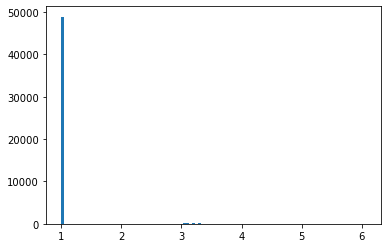

In [9]:
p1_traj = trajectory.p1_positions.values # pull p1_traj out of the trajectory dataframe
p2_traj = trajectory.p2_positions.values # pull p2_traj out of the trajectory dataframe
plt.hist([np.sqrt(np.sum((p1_traj[x]-p2_traj[x])**2, axis=0)) for x in range(len(p1_traj))],
        bins=100)

plt.show()

In [10]:
# code for creating trajectory animation as a series of png's
# you can then use the ffmpeg command (bottom of this cell) to concatenate them
import os
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm
n_past_points = 10 # number of past points to include per frame
stride = 100
p1_traj = trajectory.p1_positions.values[::stride] # pull p1_traj out of the trajectory dataframe
p2_traj = trajectory.p2_positions.values[::stride] # pull p2_traj out of the trajectory dataframe
i_traj  = trajectory['lambda'].values[::stride]  # pull the trajectory of visited ensembles out
colors  = cm.rainbow(np.linspace(0,1,len(k_i))) # color dimer by ensemble

if not os.path.exists('movie'):
    os.makedirs('movie')

for w in range(n_past_points, len(p1_traj)):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    for x in range(w-n_past_points,w):
        if np.sqrt(np.sum((p1_traj[x] - p2_traj[x]) ** 2)) > (a + 0.1):
            # change this to scatter to avoid drawing dimer bonds across the periodic box
            ax.plot([p1_traj[x][0],p2_traj[x][0]], [p1_traj[x][1],p2_traj[x][1]],
              [p1_traj[x][2],p2_traj[x][2]], color=colors[i_traj[x]])
        else:
            ax.plot([p1_traj[x][0],p2_traj[x][0]], [p1_traj[x][1],p2_traj[x][1]],
                 [p1_traj[x][2],p2_traj[x][2]], color=colors[i_traj[x]])
            
    ax.set_xlim(-L/2,L/2)
    ax.set_ylim(-L/2,L/2)
    ax.set_zlim(-L/2,L/2)
    ax.set_title(f'step =  {str(w-n_past_points).zfill(5)} : k = {i_traj[x]}')
    plt.savefig(f'movie/{str(w).zfill(5)}.png')
    plt.close()
    
# ffmpeg -framerate 60 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

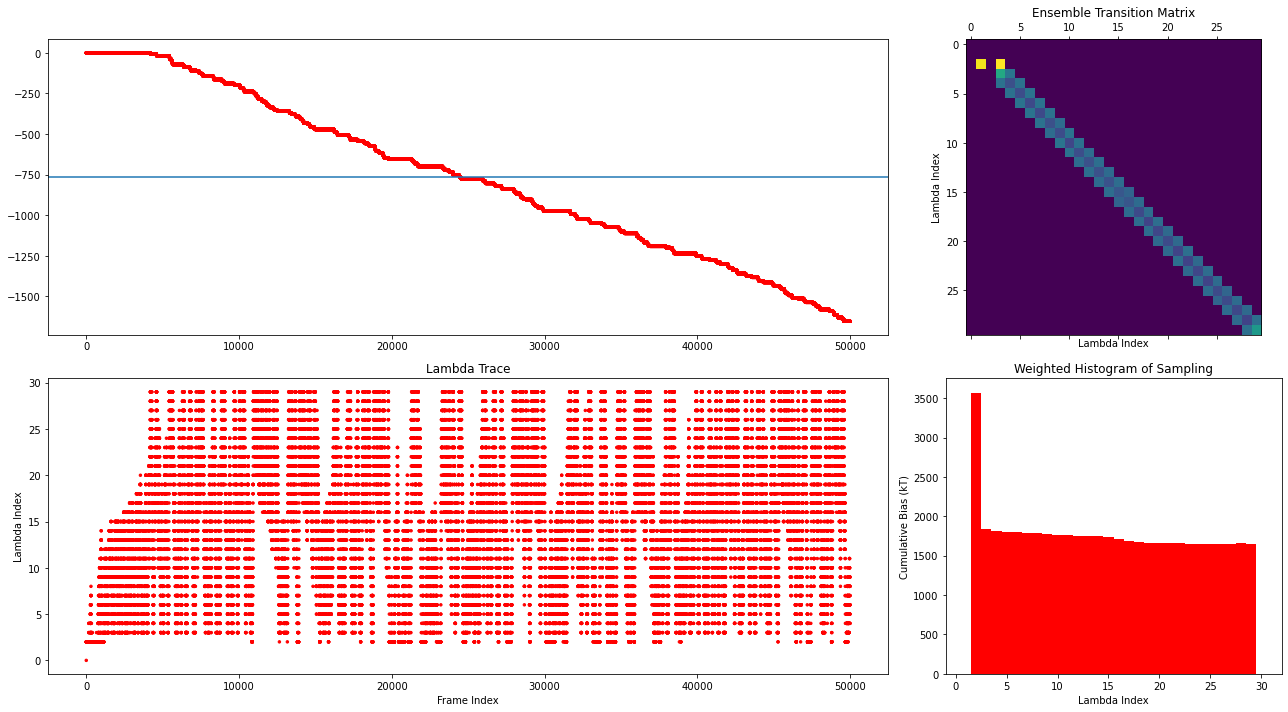

In [38]:
# JUST PLOTTING STUFF
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib import gridspec
import collections
['step','lambda','p1_positions','p2_positions',
      'increment','free_energy','dhdl']

plt.figure(figsize=(18,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[5,2])

lambda_indices = [int(x) for x in trajectory['lambda'].values]
occurrences = collections.Counter(lambda_indices)
occurrences = [occurrences[x] for x in occurrences]
weights = list(reversed(sorted(set(trajectory.increment.values))))
colors = cm.rainbow(np.linspace(1,0,len(weights)))
scatter_colors = [colors[weights.index(x)] for x in trajectory.increment.values]

# plot predicted free energy value over course of trajectory
ax0 = plt.subplot(gs[0])
ax0.scatter(range(len(trajectory.free_energy.values)), 
    trajectory.free_energy.values, s=6, c=scatter_colors)
ax0.axhline(y=np.average(trajectory.free_energy.values))
#ax0.set_ylim(free_energies[:,-1][-1]-5,free_energies[:,-1][-1]+5)

# plot overall transition matrix in lambda space
ax1 = plt.subplot(gs[1])
ax1.matshow(trajectory.transition_matrix.values[-1], cmap=plt.cm.viridis)
ax1.set_xlabel('Lambda Index')
ax1.set_ylabel('Lambda Index')
ax1.set_title(f'Ensemble Transition Matrix')

# plot lambda trace over course of trajectory
ax2 = plt.subplot(gs[2])
ax2.scatter(range(len(lambda_indices)), lambda_indices, s=6, c=scatter_colors)
ax2.set_xlabel('Frame Index')
ax2.set_ylabel('Lambda Index')
ax2.set_title(f'Lambda Trace')

# plot weighted histogram of lambda indexes colored by bias magnitude
ax3 = plt.subplot(gs[3])
barWidth = 1
increments = [float(x) for x in trajectory.increment.values]
cumulative_heights = [0 for x in range(len(k_i))]
for z,i in enumerate(reversed(sorted(set(trajectory.increment.values)))):
    wl_increment_indices = [x for x in range(len(trajectory.increment.values))
      if trajectory.increment.values[x] == i]
    lambda_indices_inc = [lambda_indices[x] for x in wl_increment_indices]
    occurrences = collections.Counter(lambda_indices_inc)
    heights = [occurrences[x]*i for x in range(1,len(k_i)+1)]
    try:
        ax3.bar(range(1,len(k_i)+1), heights, bottom=cumulative_heights, color=colors[z],
          width=barWidth)
    except Exception as e:
        print(e, len(heights), len(colors))
        continue
    cumulative_heights = [cumulative_heights[x] + heights[x] for x in range(len(k_i))]
ax3.set_xlabel('Lambda Index')
ax3.set_ylabel('Cumulative Bias (kT)')
ax3.set_title(f'Weighted Histogram of Sampling')


plt.tight_layout()
#plt.savefig(f'plot.png')
plt.show()
plt.close()

1 -2.0519761612356833 2.068167221799534
1 -1.9999267863650605 2.375675936563886
2 -2.0963501652102914 2.0406588996097073
2 -2.0592942233424965 2.092942283590671
3 -2.0160652875990226 2.008295115969532
3 -2.065612603656459 2.034005806859379


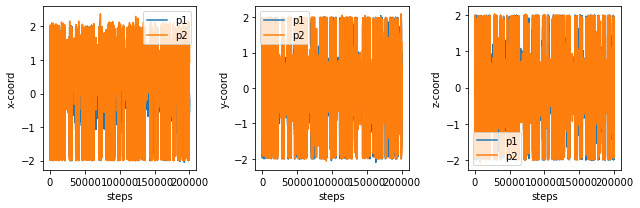

In [80]:
# Convert the trajectories to arrays
p1_traj = np.array(p1_traj)
p2_traj = np.array(p2_traj)

plt.figure(figsize=(9,3))

panel_titles = ['x-coord', 'y-coord', 'z-coord']

for panel in range(1,len(panel_titles)+1):
    plt.subplot(1,3,panel)
    # sanity check to make sure the whole trajectory is within the PBC
    print(panel, min(p1_traj[:,panel-1]), max(p1_traj[:,panel-1]))
    print(panel, min(p2_traj[:,panel-1]), max(p2_traj[:,panel-1]))
    plt.plot(np.arange(p1_traj.shape[0]), p1_traj[:,panel-1], label='p1')
    plt.plot(np.arange(p2_traj.shape[0]), p2_traj[:,panel-1], label='p2')
    plt.xlabel('steps')
    plt.ylabel(panel_titles[panel-1])
    plt.legend()
plt.tight_layout()
plt.show()

k_i = np.array([0.00, 0.09, 0.15, 0.25, 0.41, 0.67, 1.10, 1.80, 2.93, 4.74, 7.59, 11.92, 18.24, 26.89, 37.75, 50.00, 62.25, 73.11, 81.76, 88.08, 92.41, 95.26, 97.07, 98.20, 98.90, 99.33, 99.59, 99.75, 99.85, 100.00])
